# Hand Gesture Recognition: Neural Network Training and Evaluation

This notebook details the process of training and evaluating a neural network for hand gesture recognition. The primary goal is to build a robust classifier that can accurately identify different hand gestures from landmark data extracted using MediaPipe.

The process involves:
1.  **Loading Preprocessed Data**: We use datasets of hand landmarks generated by the `data_generation.ipynb` notebook.
2.  **Hyperparameter Tuning**: A systematic search is performed to find the optimal set of hyperparameters for our neural network model.
3.  **Model Training**: The model is trained on the landmark data.
4.  **Evaluation**: The trained model's performance is rigorously evaluated using various metrics and visualizations.
5.  **Saving the Best Model**: The best-performing model is saved for real-time inference in the main application.

### Table of Contents
1. [Setup and Dependencies](#setup)
2. [Model Training and Hyperparameter Tuning](#training)
3. [Performance Analysis of All Variants](#performance-analysis)
4. [In-Depth Evaluation of the Best Model](#evaluation)

<a id="setup"></a>
## 1. Setup and Dependencies

This section ensures that the environment is correctly configured to run the notebook. The following code cell installs all the necessary Python libraries listed in the `requirements.txt` file.

**How to Use:**
1.  Make sure you have Python and `pip` installed.
2.  Run the next cell to install all dependencies.

This notebook relies on data generated by `data_generation.ipynb`. If you haven't run it yet, please do so before proceeding.

In [ ]:
%pip install -r requirements.txt

<a id="training"></a>
## 2. Model Training and Hyperparameter Tuning

This is the core section of the notebook, where we train our gesture classifier. The process is designed to be robust and systematic, incorporating hyperparameter tuning to find the best model configuration.

### The Process

1.  **Load Configuration**: We start by loading application-wide settings from `app_config.json`, which includes paths to datasets and model artifacts, as well as the hyperparameter search space.
2.  **Load Datasets**: The training and validation datasets, which contain the hand landmarks and corresponding gesture IDs, are loaded from CSV files.
3.  **Hyperparameter Grid Search**: We define a grid of hyperparameters to explore. This includes different learning rates, dropout rates, batch sizes, and network architectures. The code iterates through every possible combination of these hyperparameters.
4.  **Train a Model for Each Combination**: For each set of hyperparameters, a new `GestureClassifier` is instantiated and trained. The training process uses the training data (`X_train`, `Y_train`) and evaluates performance on a validation set (`X_val`, `Y_val`) at the end of each epoch.
5.  **Evaluate and Record Performance**: After training, each model variant is evaluated against a separate evaluation dataset (`X_eval`, `Y_eval`). We calculate several regression and classification metrics to assess its performance, including:
    *   **R-squared ($R^2$)**: Measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s).\\ An $R^2$ of 1 indicates that the model perfectly predicts the data.
    *   **Mean Squared Error (MSE)**: The average of the squares of the errors. It is sensitive to large errors.
    *   **Mean Absolute Error (MAE)**: The average of the absolute differences between predictions and actual values. It is less sensitive to outliers than MSE.
6.  **Identify and Save the Best Model**: After all variants have been trained and evaluated, we identify the best-performing model based on the highest validation R2-Score and lowest validation loss. This model is then saved to a file (`gesture_model.h5`) for use in the application. All performance metrics are saved to `models_performance.csv`.

In [3]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from src.gesture_controller.gesture_classifier import GestureClassifier
from src.gesture_controller.app_config import AppConfig
import itertools as itertools
import pandas as pd
import numpy as np
import sys
import os

# --- Load Configuration ---
config = AppConfig()
data_generation_config = config.get_app_config("DATA_GENERATION_CONFIG")
datase_train_path = data_generation_config.get("DATASET_TRAINING_PATH")
datase_val_path = data_generation_config.get("DATASET_VAL_PATH")

model_path = config.get_neural_network_config().get('MODEL_PATH')
model_performance_path = config.get_neural_network_config().get('MODEL_PERFORMANCE_PATH')
hyperparam_config = config.get_hyperparameter_config()


# --- Load and Prepare Dataset ---
try:
    # Load training dataset from CSV
    df_train = pd.read_csv(datase_train_path)
    df_train['LANDMARKS'] = df_train['LANDMARKS'].apply(eval)
    X = np.array(df_train['LANDMARKS'].tolist())
    Y = df_train['GESTURE_ID']

    # Load validation/evaluation dataset from CSV
    df_eval = pd.read_csv(datase_val_path)
    df_eval['LANDMARKS'] = df_eval['LANDMARKS'].apply(eval)
    X_eval = np.array(df_eval['LANDMARKS'].tolist())
    Y_eval = df_eval['GESTURE_ID']

    # Dynamically determine number of classes based on highest gesture ID
    max_gesture_id = Y.max()
    num_classes = max_gesture_id + 1

    # Split the data into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    # --- Hyperparameter Tuning ---
    hyperparam_keys = list(hyperparam_config.keys())
    hyperparam_values = list(hyperparam_config.values())

    # Generate all combinations
    hyperparam_combinations = list(itertools.product(*hyperparam_values))

    print(f"Total hyperparameter combinations: {len(hyperparam_combinations)}")

    training_history = []
    best_model = None
    best_val_accuracy = 0
    best_val_loss = float('inf')

    # Iterate over all hyperparameter combinations
    for i, params in enumerate(hyperparam_combinations):
        
        hyperparams = dict(zip(hyperparam_keys, params))
        
        print(f"--- Training Variant {i+1}/{len(hyperparam_combinations)} ---")
        print(f"Hyperparameters: {hyperparams}")
        
        # Create a new classifier for each hyperparameter combination
        classifier = GestureClassifier(num_classes=num_classes, input_size=X_train.shape[1], hyperparams=hyperparams)

        # Train the model
        model, history = classifier.train(
            X_train, Y_train, X_val, Y_val, 
            batch_size=hyperparams['BATCH_SIZE'], 
            epochs=hyperparams['EPOCHS']
        )

        Y_pred = classifier.evaluate(X_eval)

        score_val_accuracy = history.history['val_accuracy'][-1]
        score_val_loss = history.history['val_loss'][-1]
        score_val_r2 = r2_score(Y_eval, Y_pred)
        score_val_mse = mean_squared_error(Y_eval, Y_pred)
        score_val_mae = mean_absolute_error(Y_eval, Y_pred)
        score_val_mape = mean_absolute_percentage_error(Y_eval, Y_pred)
        
        print(f"R2 Score: {score_val_r2:.4f}")
        print(f"MSE: {score_val_mse:.4f}")
        print(f"MAE: {score_val_mae:.4f}")
        print(f"MAPE: {score_val_mape:.4f}")

        # Store history
        run_info = {
            'variant': i + 1,
            'hyperparameters': hyperparams,
            'val_accuracy': score_val_accuracy,
            'val_loss': score_val_loss,
            'val_r2': score_val_r2,
            'val_mse': score_val_mse,
            'val_mae': score_val_mae,
            'val_mape': score_val_mape,
            'history': history.history,
            'model': model
        }
        training_history.append(run_info)

    # Display results
    history_df = pd.DataFrame(training_history)
    history_df.to_csv(model_performance_path)

    best_run = min(training_history, key=lambda x: (1 - x['val_r2'], x['val_loss']))
    
    print("\n--- Best Model Found ---")
    print(f"Parameters: {best_run['hyperparameters']}")
    print(f"R2 Score: {best_run['val_r2']:.4f}")
    print(f"MSE: {best_run['val_mse']:.4f}")
    print(f"MAE: {best_run['val_mae']:.4f}")
    print(f"MAPE: {best_run['val_mape']:.4f}")
    
    best_run['model'].save(model_path)


except FileNotFoundError:
    print(f"Error: Dataset file not found at '{datase_train_path}'.")
    print("Please run the data generation notebook first.")
except Exception as e:
    print(f"An error occurred: {e}")

Total hyperparameter combinations: 72
--- Training Variant 1/72 ---
Hyperparameters: {'DENSE_LAYERS': [128, 64, 32], 'ACTIVATION': 'relu', 'DROPOUT_RATE': 0.2, 'LEARNING_RATE': 0.01, 'BATCH_SIZE': 32, 'EPOCHS': 50}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8291 - loss: 0.4345 - val_accuracy: 0.9970 - val_loss: 0.0182
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8291 - loss: 0.4345 - val_accuracy: 0.9970 - val_loss: 0.0182
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.9851 - loss: 0.0522 - val_accuracy: 0.9926 - val_loss: 0.0271
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.9851 - loss: 0.0522 - val_accuracy: 0.9926 - val_loss: 0.0271
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.9859 - loss: 0.0383 - val_accuracy: 1.0000 - val_loss: 1.4433e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.9859 - loss: 0.0383 - val_accuracy: 1.0000 - val_loss: 1.4433e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.9855 - loss: 0.0827 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.9855 - loss: 0.0827 - val_accuracy

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7905 - loss: 0.5516 - val_accuracy: 0.9941 - val_loss: 0.0318
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7905 - loss: 0.5516 - val_accuracy: 0.9941 - val_loss: 0.0318
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9840 - loss: 0.0532 - val_accuracy: 1.0000 - val_loss: 8.8703e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9840 - loss: 0.0532 - val_accuracy: 1.0000 - val_loss: 8.8703e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9922 - loss: 0.0270 - val_accuracy: 0.9911 - val_loss: 0.0179
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9922 - loss: 0.0270 - val_accuracy: 0.9911 - val_loss: 0.0179
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9948 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 2.1494e-05
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9948 - loss: 0.0173 - val_accuracy: 1.0000

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6230 - loss: 1.1438 - val_accuracy: 0.9450 - val_loss: 0.3764
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6230 - loss: 1.1438 - val_accuracy: 0.9450 - val_loss: 0.3764
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.8934 - loss: 0.3323 - val_accuracy: 0.9955 - val_loss: 0.0847
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.8934 - loss: 0.3323 - val_accuracy: 0.9955 - val_loss: 0.0847
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.9736 - loss: 0.1194 - val_accuracy: 0.9985 - val_loss: 0.0181
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.9736 - loss: 0.1194 - val_accuracy: 0.9985 - val_loss: 0.0181
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9825 - loss: 0.0691 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9825 - loss: 0.0691 - val_accuracy: 1.0000

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5449 - loss: 1.4974 - val_accuracy: 0.8098 - val_loss: 0.7857
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5449 - loss: 1.4974 - val_accuracy: 0.8098 - val_loss: 0.7857
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7741 - loss: 0.6584 - val_accuracy: 0.9762 - val_loss: 0.2937
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7741 - loss: 0.6584 - val_accuracy: 0.9762 - val_loss: 0.2937
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8919 - loss: 0.3288 - val_accuracy: 0.9970 - val_loss: 0.1031
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8919 - loss: 0.3288 - val_accuracy: 0.9970 - val_loss: 0.1031
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9539 - loss: 0.1661 - val_accuracy: 0.9985 - val_loss: 0.0315
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9539 - loss: 0.1661 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7337 - loss: 0.6393 - val_accuracy: 0.9985 - val_loss: 0.0885
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7337 - loss: 0.6393 - val_accuracy: 0.9985 - val_loss: 0.0885
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.9480 - loss: 0.1450 - val_accuracy: 0.9926 - val_loss: 0.0290
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.9480 - loss: 0.1450 - val_accuracy: 0.9926 - val_loss: 0.0290
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.9892 - loss: 0.0361 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.9892 - loss: 0.0361 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.9866 - loss: 0.0465 - val_accuracy: 1.0000 - val_loss: 6.7702e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.9866 - loss: 0.0465 - val_accuracy: 1.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6215 - loss: 0.8712 - val_accuracy: 0.7459 - val_loss: 0.3239
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6215 - loss: 0.8712 - val_accuracy: 0.7459 - val_loss: 0.3239
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778 - loss: 0.2950 - val_accuracy: 0.9985 - val_loss: 0.0176
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778 - loss: 0.2950 - val_accuracy: 0.9985 - val_loss: 0.0176
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9629 - loss: 0.1018 - val_accuracy: 0.9985 - val_loss: 0.0035
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9629 - loss: 0.1018 - val_accuracy: 0.9985 - val_loss: 0.0035
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9770 - loss: 0.0647 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9770 - loss: 0.0647 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5851 - loss: 1.1748 - val_accuracy: 0.8737 - val_loss: 0.4286
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5851 - loss: 1.1748 - val_accuracy: 0.8737 - val_loss: 0.4286
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7964 - loss: 0.4895 - val_accuracy: 0.9851 - val_loss: 0.1785
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7964 - loss: 0.4895 - val_accuracy: 0.9851 - val_loss: 0.1785
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.9097 - loss: 0.2691 - val_accuracy: 1.0000 - val_loss: 0.0623
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.9097 - loss: 0.2691 - val_accuracy: 1.0000 - val_loss: 0.0623
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.9577 - loss: 0.1501 - val_accuracy: 1.0000 - val_loss: 0.0164
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.9577 - loss: 0.1501 - val_accuracy: 1.0000

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4959 - loss: 1.5484 - val_accuracy: 0.7028 - val_loss: 0.8471
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4959 - loss: 1.5484 - val_accuracy: 0.7028 - val_loss: 0.8471
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7132 - loss: 0.8313 - val_accuracy: 0.9762 - val_loss: 0.3709
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7132 - loss: 0.8313 - val_accuracy: 0.9762 - val_loss: 0.3709
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8098 - loss: 0.5388 - val_accuracy: 0.9911 - val_loss: 0.1809
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8098 - loss: 0.5388 - val_accuracy: 0.9911 - val_loss: 0.1809
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8971 - loss: 0.3312 - val_accuracy: 1.0000 - val_loss: 0.0730
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8971 - loss: 0.3312 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5498 - loss: 0.9920 - val_accuracy: 0.9554 - val_loss: 0.3609
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5498 - loss: 0.9920 - val_accuracy: 0.9554 - val_loss: 0.3609
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.7883 - loss: 0.4518 - val_accuracy: 0.8900 - val_loss: 0.1754
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.7883 - loss: 0.4518 - val_accuracy: 0.8900 - val_loss: 0.1754
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.9056 - loss: 0.2607 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.9056 - loss: 0.2607 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.9383 - loss: 0.1986 - val_accuracy: 0.9985 - val_loss: 0.0043
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.9383 - loss: 0.1986 - val_accuracy: 0.9985

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5970 - loss: 0.9214 - val_accuracy: 0.7459 - val_loss: 0.3535
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5970 - loss: 0.9214 - val_accuracy: 0.7459 - val_loss: 0.3535
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8392 - loss: 0.3753 - val_accuracy: 0.9599 - val_loss: 0.1062
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8392 - loss: 0.3753 - val_accuracy: 0.9599 - val_loss: 0.1062
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9261 - loss: 0.1997 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9261 - loss: 0.1997 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9439 - loss: 0.1552 - val_accuracy: 0.9985 - val_loss: 0.0116
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9439 - loss: 0.1552 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4383 - loss: 1.5439 - val_accuracy: 0.7920 - val_loss: 0.7359
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4383 - loss: 1.5439 - val_accuracy: 0.7920 - val_loss: 0.7359
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.6631 - loss: 0.8677 - val_accuracy: 0.9703 - val_loss: 0.3412
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.6631 - loss: 0.8677 - val_accuracy: 0.9703 - val_loss: 0.3412
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.7916 - loss: 0.5619 - val_accuracy: 0.9955 - val_loss: 0.1568
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.7916 - loss: 0.5619 - val_accuracy: 0.9955 - val_loss: 0.1568
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.8655 - loss: 0.3786 - val_accuracy: 0.9985 - val_loss: 0.0742
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.8655 - loss: 0.3786 - val_accuracy: 0.9985

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3503 - loss: 1.7372 - val_accuracy: 0.8217 - val_loss: 1.0971
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3503 - loss: 1.7372 - val_accuracy: 0.8217 - val_loss: 1.0971
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5516 - loss: 1.1589 - val_accuracy: 0.8886 - val_loss: 0.6389
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5516 - loss: 1.1589 - val_accuracy: 0.8886 - val_loss: 0.6389
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6564 - loss: 0.8675 - val_accuracy: 0.9198 - val_loss: 0.4114
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6564 - loss: 0.8675 - val_accuracy: 0.9198 - val_loss: 0.4114
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7470 - loss: 0.6553 - val_accuracy: 0.9926 - val_loss: 0.2476
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7470 - loss: 0.6553 - val_accuracy: 0.9926 - val_loss:

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9071 - loss: 0.2660 - val_accuracy: 1.0000 - val_loss: 0.0068
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9071 - loss: 0.2660 - val_accuracy: 1.0000 - val_loss: 0.0068
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.9981 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.9981 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.9959 - loss: 0.0188 - val_accuracy: 0.9985 - val_loss: 0.0041
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.9959 - loss: 0.0188 - val_accuracy: 0.9985 - val_loss: 0.0041
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8577 - loss: 0.4280 - val_accuracy: 0.9985 - val_loss: 0.0260
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8577 - loss: 0.4280 - val_accuracy: 0.9985 - val_loss: 0.0260
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0199 - val_accuracy: 0.9985 - val_loss: 0.0049
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0199 - val_accuracy: 0.9985 - val_loss: 0.0049
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.9985 - val_loss: 0.0032
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.9985 - val_loss: 0.0032
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9985 - val_loss: 0.0029
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7823 - loss: 0.8247 - val_accuracy: 0.9911 - val_loss: 0.2600
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7823 - loss: 0.8247 - val_accuracy: 0.9911 - val_loss: 0.2600
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.9926 - loss: 0.1766 - val_accuracy: 1.0000 - val_loss: 0.0609
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.9926 - loss: 0.1766 - val_accuracy: 1.0000 - val_loss: 0.0609
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.9993 - loss: 0.0656 - val_accuracy: 1.0000 - val_loss: 0.0258
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.9993 - loss: 0.0656 - val_accuracy: 1.0000 - val_loss: 0.0258
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 1.0000 - loss: 0.0358 - val_accuracy: 1.0000 - val_loss: 0.0145
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 1.0000 - loss: 0.0358 - val_accuracy: 1.0000

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6352 - loss: 1.1154 - val_accuracy: 0.9673 - val_loss: 0.5658
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6352 - loss: 1.1154 - val_accuracy: 0.9673 - val_loss: 0.5658
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8993 - loss: 0.4746 - val_accuracy: 0.9941 - val_loss: 0.2802
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8993 - loss: 0.4746 - val_accuracy: 0.9941 - val_loss: 0.2802
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9811 - loss: 0.2467 - val_accuracy: 1.0000 - val_loss: 0.1269
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9811 - loss: 0.2467 - val_accuracy: 1.0000 - val_loss: 0.1269
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.1348 - val_accuracy: 0.9985 - val_loss: 0.0677
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.1348 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8815 - loss: 0.3182 - val_accuracy: 0.9985 - val_loss: 0.0073
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8815 - loss: 0.3182 - val_accuracy: 0.9985 - val_loss: 0.0073
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.9707 - loss: 0.1215 - val_accuracy: 0.9911 - val_loss: 0.0435
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.9707 - loss: 0.1215 - val_accuracy: 0.9911 - val_loss: 0.0435
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.9937 - loss: 0.0312 - val_accuracy: 0.9985 - val_loss: 0.0024
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.9937 - loss: 0.0312 - val_accuracy: 0.9985 - val_loss: 0.0024
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0549 - val_accuracy: 0.9777 - val_loss: 0.0498
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0549 - val_accuracy: 0.9777 - v

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8206 - loss: 0.5195 - val_accuracy: 0.9941 - val_loss: 0.0495
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8206 - loss: 0.5195 - val_accuracy: 0.9941 - val_loss: 0.0495
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9848 - loss: 0.0654 - val_accuracy: 0.8737 - val_loss: 0.3121
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9848 - loss: 0.0654 - val_accuracy: 0.8737 - val_loss: 0.3121
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0324 - val_accuracy: 0.9985 - val_loss: 0.0096
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0324 - val_accuracy: 0.9985 - val_loss: 0.0096
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.9985 - val_loss: 0.0090
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6928 - loss: 0.9631 - val_accuracy: 0.9762 - val_loss: 0.3919
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6928 - loss: 0.9631 - val_accuracy: 0.9762 - val_loss: 0.3919
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.9435 - loss: 0.3498 - val_accuracy: 0.9985 - val_loss: 0.1166
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.9435 - loss: 0.3498 - val_accuracy: 0.9985 - val_loss: 0.1166
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.9892 - loss: 0.1535 - val_accuracy: 0.9985 - val_loss: 0.0438
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.9892 - loss: 0.1535 - val_accuracy: 0.9985 - val_loss: 0.0438
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.9952 - loss: 0.0845 - val_accuracy: 0.9985 - val_loss: 0.0229
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.9952 - loss: 0.0845 - val_accuracy: 0.9985

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5929 - loss: 1.2075 - val_accuracy: 0.9718 - val_loss: 0.5922
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5929 - loss: 1.2075 - val_accuracy: 0.9718 - val_loss: 0.5922
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8648 - loss: 0.5531 - val_accuracy: 0.9970 - val_loss: 0.2822
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8648 - loss: 0.5531 - val_accuracy: 0.9970 - val_loss: 0.2822
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9528 - loss: 0.2964 - val_accuracy: 0.9985 - val_loss: 0.1323
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9528 - loss: 0.2964 - val_accuracy: 0.9985 - val_loss: 0.1323
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9874 - loss: 0.1734 - val_accuracy: 1.0000 - val_loss: 0.0689
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9874 - loss: 0.1734 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7868 - loss: 0.5442 - val_accuracy: 0.9777 - val_loss: 0.0860
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7868 - loss: 0.5442 - val_accuracy: 0.9777 - val_loss: 0.0860
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.9751 - loss: 0.1051 - val_accuracy: 0.9985 - val_loss: 0.0053
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.9751 - loss: 0.1051 - val_accuracy: 0.9985 - val_loss: 0.0053
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.9833 - loss: 0.0687 - val_accuracy: 0.9733 - val_loss: 0.0410
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.9833 - loss: 0.0687 - val_accuracy: 0.9733 - val_loss: 0.0410
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.9736 - loss: 0.0797 - val_accuracy: 0.9985 - val_loss: 0.0032
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.9736 - loss: 0.0797 - val_accuracy: 0.9985

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7199 - loss: 0.7619 - val_accuracy: 0.9807 - val_loss: 0.0821
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7199 - loss: 0.7619 - val_accuracy: 0.9807 - val_loss: 0.0821
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9655 - loss: 0.1355 - val_accuracy: 0.9941 - val_loss: 0.0202
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9655 - loss: 0.1355 - val_accuracy: 0.9941 - val_loss: 0.0202
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0473 - val_accuracy: 0.9985 - val_loss: 0.0059
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0473 - val_accuracy: 0.9985 - val_loss: 0.0059
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - loss: 0.0373 - val_accuracy: 0.9985 - val_loss: 0.0036
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - loss: 0.0373 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5999 - loss: 1.1397 - val_accuracy: 0.9569 - val_loss: 0.5025
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5999 - loss: 1.1397 - val_accuracy: 0.9569 - val_loss: 0.5025
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.8484 - loss: 0.5522 - val_accuracy: 0.9926 - val_loss: 0.2168
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.8484 - loss: 0.5522 - val_accuracy: 0.9926 - val_loss: 0.2168
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.9395 - loss: 0.3138 - val_accuracy: 0.9970 - val_loss: 0.0957
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.9395 - loss: 0.3138 - val_accuracy: 0.9970 - val_loss: 0.0957
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9714 - loss: 0.1977 - val_accuracy: 0.9985 - val_loss: 0.0431
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9714 - loss: 0.1977 - val_accuracy: 0.9985

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_92 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4993 - loss: 1.3608 - val_accuracy: 0.8707 - val_loss: 0.6774
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4993 - loss: 1.3608 - val_accuracy: 0.8707 - val_loss: 0.6774
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7266 - loss: 0.7573 - val_accuracy: 0.9866 - val_loss: 0.4243
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7266 - loss: 0.7573 - val_accuracy: 0.9866 - val_loss: 0.4243
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8414 - loss: 0.5453 - val_accuracy: 1.0000 - val_loss: 0.2534
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8414 - loss: 0.5453 - val_accuracy: 1.0000 - val_loss: 0.2534
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9201 - loss: 0.3765 - val_accuracy: 1.0000 - val_loss: 0.1491
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9201 - loss: 0.3765 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4863 - loss: 1.3842 - val_accuracy: 0.7712 - val_loss: 0.5806
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4863 - loss: 1.3842 - val_accuracy: 0.7712 - val_loss: 0.5806
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.8265 - loss: 0.4333 - val_accuracy: 0.9881 - val_loss: 0.1858
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.8265 - loss: 0.4333 - val_accuracy: 0.9881 - val_loss: 0.1858
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.9803 - loss: 0.1321 - val_accuracy: 1.0000 - val_loss: 0.0282
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.9803 - loss: 0.1321 - val_accuracy: 1.0000 - val_loss: 0.0282
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.9941 - loss: 0.0541 - val_accuracy: 0.9851 - val_loss: 0.0477
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.9941 - loss: 0.0541 - val_accuracy: 0.9851

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3614 - loss: 1.7416 - val_accuracy: 0.5527 - val_loss: 1.0643
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3614 - loss: 1.7416 - val_accuracy: 0.5527 - val_loss: 1.0643
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6571 - loss: 0.7909 - val_accuracy: 0.7786 - val_loss: 0.5149
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6571 - loss: 0.7909 - val_accuracy: 0.7786 - val_loss: 0.5149
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7942 - loss: 0.4322 - val_accuracy: 0.9851 - val_loss: 0.2540
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7942 - loss: 0.4322 - val_accuracy: 0.9851 - val_loss: 0.2540
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9584 - loss: 0.1885 - val_accuracy: 0.9985 - val_loss: 0.0596
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9584 - loss: 0.1885 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_104 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1742 - loss: 2.0643 - val_accuracy: 0.5097 - val_loss: 1.9283
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1742 - loss: 2.0643 - val_accuracy: 0.5097 - val_loss: 1.9283
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.3466 - loss: 1.8021 - val_accuracy: 0.6137 - val_loss: 1.5940
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.3466 - loss: 1.8021 - val_accuracy: 0.6137 - val_loss: 1.5940
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.4989 - loss: 1.4551 - val_accuracy: 0.6033 - val_loss: 1.2337
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.4989 - loss: 1.4551 - val_accuracy: 0.6033 - val_loss: 1.2337
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.6010 - loss: 1.1384 - val_accuracy: 0.6999 - val_loss: 0.9483
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.6010 - loss: 1.1384 - val_accuracy: 0.6999

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1367 - loss: 2.1190 - val_accuracy: 0.3967 - val_loss: 2.0160
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1367 - loss: 2.1190 - val_accuracy: 0.3967 - val_loss: 2.0160
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2463 - loss: 1.9787 - val_accuracy: 0.4279 - val_loss: 1.8797
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2463 - loss: 1.9787 - val_accuracy: 0.4279 - val_loss: 1.8797
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3845 - loss: 1.7921 - val_accuracy: 0.5215 - val_loss: 1.6443
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3845 - loss: 1.7921 - val_accuracy: 0.5215 - val_loss: 1.6443
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4673 - loss: 1.5561 - val_accuracy: 0.5750 - val_loss: 1.3884
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4673 - loss: 1.5561 - val_accuracy: 0.5750 - val_loss:

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4458 - loss: 1.4744 - val_accuracy: 0.7786 - val_loss: 0.6472
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4458 - loss: 1.4744 - val_accuracy: 0.7786 - val_loss: 0.6472
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7942 - loss: 0.5304 - val_accuracy: 0.9346 - val_loss: 0.2373
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7942 - loss: 0.5304 - val_accuracy: 0.9346 - val_loss: 0.2373
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.9079 - loss: 0.2669 - val_accuracy: 0.9792 - val_loss: 0.0916
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.9079 - loss: 0.2669 - val_accuracy: 0.9792 - val_loss: 0.0916
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.9718 - loss: 0.1254 - val_accuracy: 1.0000 - val_loss: 0.0170
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.9718 - loss: 0.1254 - val_accuracy: 1.0000

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_116 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3158 - loss: 1.7819 - val_accuracy: 0.4458 - val_loss: 1.2016
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3158 - loss: 1.7819 - val_accuracy: 0.4458 - val_loss: 1.2016
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5970 - loss: 0.9563 - val_accuracy: 0.7637 - val_loss: 0.5629
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5970 - loss: 0.9563 - val_accuracy: 0.7637 - val_loss: 0.5629
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7155 - loss: 0.5882 - val_accuracy: 0.7459 - val_loss: 0.4157
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7155 - loss: 0.5882 - val_accuracy: 0.7459 - val_loss: 0.4157
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8109 - loss: 0.4327 - val_accuracy: 0.9718 - val_loss: 0.2434
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8109 - loss: 0.4327 - val_accuracy: 0.9718 - val_loss:

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1549 - loss: 2.1170 - val_accuracy: 0.3611 - val_loss: 1.9929
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1549 - loss: 2.1170 - val_accuracy: 0.3611 - val_loss: 1.9929
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.2790 - loss: 1.9177 - val_accuracy: 0.5527 - val_loss: 1.6962
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.2790 - loss: 1.9177 - val_accuracy: 0.5527 - val_loss: 1.6962
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.4120 - loss: 1.5801 - val_accuracy: 0.6256 - val_loss: 1.3092
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.4120 - loss: 1.5801 - val_accuracy: 0.6256 - val_loss: 1.3092
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.5171 - loss: 1.2705 - val_accuracy: 0.6077 - val_loss: 1.0489
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.5171 - loss: 1.2705 - val_accuracy: 0.6077

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_124 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1363 - loss: 2.1283 - val_accuracy: 0.2556 - val_loss: 2.0105
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1363 - loss: 2.1283 - val_accuracy: 0.2556 - val_loss: 2.0105
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2125 - loss: 2.0026 - val_accuracy: 0.4012 - val_loss: 1.8747
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2125 - loss: 2.0026 - val_accuracy: 0.4012 - val_loss: 1.8747
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3328 - loss: 1.8215 - val_accuracy: 0.5111 - val_loss: 1.6579
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3328 - loss: 1.8215 - val_accuracy: 0.5111 - val_loss: 1.6579
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4071 - loss: 1.6110 - val_accuracy: 0.5988 - val_loss: 1.4266
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4071 - loss: 1.6110 - val_accuracy: 0.5988 - val_loss:

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_128 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3447 - loss: 1.6824 - val_accuracy: 0.6642 - val_loss: 0.8586
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3447 - loss: 1.6824 - val_accuracy: 0.6642 - val_loss: 0.8586
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.6215 - loss: 0.7850 - val_accuracy: 0.7429 - val_loss: 0.5033
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.6215 - loss: 0.7850 - val_accuracy: 0.7429 - val_loss: 0.5033
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.7021 - loss: 0.5602 - val_accuracy: 0.8098 - val_loss: 0.3741
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.7021 - loss: 0.5602 - val_accuracy: 0.8098 - val_loss: 0.3741
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7871 - loss: 0.4284 - val_accuracy: 0.8722 - val_loss: 0.2120
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7871 - loss: 0.4284 - val_accuracy: 0.8722

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2920 - loss: 1.8798 - val_accuracy: 0.5290 - val_loss: 1.2643
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2920 - loss: 1.8798 - val_accuracy: 0.5290 - val_loss: 1.2643
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5520 - loss: 1.0811 - val_accuracy: 0.6924 - val_loss: 0.6367
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5520 - loss: 1.0811 - val_accuracy: 0.6924 - val_loss: 0.6367
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6679 - loss: 0.7126 - val_accuracy: 0.7519 - val_loss: 0.4672
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6679 - loss: 0.7126 - val_accuracy: 0.7519 - val_loss: 0.4672
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7084 - loss: 0.5697 - val_accuracy: 0.8440 - val_loss: 0.3996
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7084 - loss: 0.5697 - val_accuracy: 0.8440 - val_loss:

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_136 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1482 - loss: 2.1489 - val_accuracy: 0.4398 - val_loss: 2.0135
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1482 - loss: 2.1489 - val_accuracy: 0.4398 - val_loss: 2.0135
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.1947 - loss: 2.0334 - val_accuracy: 0.6360 - val_loss: 1.8667
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.1947 - loss: 2.0334 - val_accuracy: 0.6360 - val_loss: 1.8667
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.3336 - loss: 1.8115 - val_accuracy: 0.5765 - val_loss: 1.5414
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.3336 - loss: 1.8115 - val_accuracy: 0.5765 - val_loss: 1.5414
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.4328 - loss: 1.5276 - val_accuracy: 0.6360 - val_loss: 1.2343
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.4328 - loss: 1.5276 - val_accuracy: 0.6360

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1233 - loss: 2.2127 - val_accuracy: 0.1441 - val_loss: 2.0374
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1233 - loss: 2.2127 - val_accuracy: 0.1441 - val_loss: 2.0374
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1486 - loss: 2.1040 - val_accuracy: 0.3967 - val_loss: 1.9913
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1486 - loss: 2.1040 - val_accuracy: 0.3967 - val_loss: 1.9913
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1906 - loss: 2.0249 - val_accuracy: 0.4933 - val_loss: 1.8952
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1906 - loss: 2.0249 - val_accuracy: 0.4933 - val_loss: 1.8952
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2730 - loss: 1.9018 - val_accuracy: 0.5260 - val_loss: 1.7285
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2730 - loss: 1.9018 - val_accuracy: 0.5260 - val_loss:

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8447 - loss: 0.3685 - val_accuracy: 0.9955 - val_loss: 0.0222
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8447 - loss: 0.3685 - val_accuracy: 0.9955 - val_loss: 0.0222
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9907 - loss: 0.0296 - val_accuracy: 0.9970 - val_loss: 0.0097
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9907 - loss: 0.0296 - val_accuracy: 0.9970 - val_loss: 0.0097
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9903 - loss: 0.0315 - val_accuracy: 0.9985 - val_loss: 0.0081
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9903 - loss: 0.0315 - val_accuracy: 0.9985 - val_loss: 0.0081
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0390 - val_accuracy: 1.0000 - val_loss: 1.6846e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0390 - val_accuracy: 1.0000 - val_l

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8336 - loss: 0.4240 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8336 - loss: 0.4240 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 1.5937e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 1.5937e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0205 - val_accuracy: 0.9569 - val_loss: 0.0999
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0205 - val_accuracy: 0.9569 - val_loss: 0.0999
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9859 - loss: 0.0515 - val_accuracy: 0.9970 - val_loss: 0.0046
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9859 - loss: 0.0515 - val_accuracy: 0.9970 - v

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_152 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7786 - loss: 0.7697 - val_accuracy: 1.0000 - val_loss: 0.0948
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7786 - loss: 0.7697 - val_accuracy: 1.0000 - val_loss: 0.0948
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9855 - loss: 0.0762 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9855 - loss: 0.0762 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9981 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9981 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_156 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6579 - loss: 1.0947 - val_accuracy: 0.9331 - val_loss: 0.3329
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6579 - loss: 1.0947 - val_accuracy: 0.9331 - val_loss: 0.3329
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8822 - loss: 0.2953 - val_accuracy: 0.9881 - val_loss: 0.1042
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8822 - loss: 0.2953 - val_accuracy: 0.9881 - val_loss: 0.1042
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0966 - val_accuracy: 0.9985 - val_loss: 0.0169
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0966 - val_accuracy: 0.9985 - val_loss: 0.0169
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_160 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8172 - loss: 0.4542 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8172 - loss: 0.4542 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9781 - loss: 0.0750 - val_accuracy: 0.9985 - val_loss: 0.0047
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9781 - loss: 0.0750 - val_accuracy: 0.9985 - val_loss: 0.0047
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - loss: 0.0178 - val_accuracy: 0.9896 - val_loss: 0.0522
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - loss: 0.0178 - val_accuracy: 0.9896 - val_loss: 0.0522
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9848 - loss: 0.0604 - val_accuracy: 1.0000 - val_loss: 3.9903e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9848 - loss: 0.0604 - val_accuracy: 1.0000 - val_l

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_164 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7983 - loss: 0.5060 - val_accuracy: 1.0000 - val_loss: 0.0101
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7983 - loss: 0.5060 - val_accuracy: 1.0000 - val_loss: 0.0101
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0524 - val_accuracy: 0.9985 - val_loss: 0.0057
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0524 - val_accuracy: 0.9985 - val_loss: 0.0057
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0681 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0681 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 2.4161e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0144 - val_accuracy: 1.0000 - val_l

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6657 - loss: 0.9165 - val_accuracy: 0.8588 - val_loss: 0.2643
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6657 - loss: 0.9165 - val_accuracy: 0.8588 - val_loss: 0.2643
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9398 - loss: 0.2040 - val_accuracy: 0.9985 - val_loss: 0.0239
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9398 - loss: 0.2040 - val_accuracy: 0.9985 - val_loss: 0.0239
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0488 - val_accuracy: 0.9985 - val_loss: 0.0052
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0488 - val_accuracy: 0.9985 - val_loss: 0.0052
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_172 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6285 - loss: 1.1665 - val_accuracy: 0.9673 - val_loss: 0.3600
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6285 - loss: 1.1665 - val_accuracy: 0.9673 - val_loss: 0.3600
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8629 - loss: 0.3840 - val_accuracy: 0.9955 - val_loss: 0.0847
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8629 - loss: 0.3840 - val_accuracy: 0.9955 - val_loss: 0.0847
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9721 - loss: 0.1266 - val_accuracy: 1.0000 - val_loss: 0.0169
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9721 - loss: 0.1266 - val_accuracy: 1.0000 - val_loss: 0.0169
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0569 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0569 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_176 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7689 - loss: 0.5827 - val_accuracy: 0.9926 - val_loss: 0.0261
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7689 - loss: 0.5827 - val_accuracy: 0.9926 - val_loss: 0.0261
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9755 - loss: 0.0934 - val_accuracy: 0.9480 - val_loss: 0.1646
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9755 - loss: 0.0934 - val_accuracy: 0.9480 - val_loss: 0.1646
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9692 - loss: 0.1442 - val_accuracy: 0.9985 - val_loss: 0.0086
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9692 - loss: 0.1442 - val_accuracy: 0.9985 - val_loss: 0.0086
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9669 - loss: 0.1471 - val_accuracy: 0.9926 - val_loss: 0.0191
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9669 - loss: 0.1471 - val_accuracy: 0.9926 - val_loss:

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7088 - loss: 0.7381 - val_accuracy: 1.0000 - val_loss: 0.0318
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7088 - loss: 0.7381 - val_accuracy: 1.0000 - val_loss: 0.0318
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1482 - val_accuracy: 1.0000 - val_loss: 7.1183e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1482 - val_accuracy: 1.0000 - val_loss: 7.1183e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0508 - val_accuracy: 1.0000 - val_loss: 5.9930e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0508 - val_accuracy: 1.0000 - val_loss: 5.9930e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0302 - val_accuracy: 1.0000 - val_loss: 1.6364e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0302 - val_accuracy

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_184 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5724 - loss: 1.1263 - val_accuracy: 0.8886 - val_loss: 0.3807
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5724 - loss: 1.1263 - val_accuracy: 0.8886 - val_loss: 0.3807
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8250 - loss: 0.4508 - val_accuracy: 0.9985 - val_loss: 0.0902
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8250 - loss: 0.4508 - val_accuracy: 0.9985 - val_loss: 0.0902
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9513 - loss: 0.1739 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9513 - loss: 0.1739 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9755 - loss: 0.0889 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9755 - loss: 0.0889 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_188 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4900 - loss: 1.4205 - val_accuracy: 0.8455 - val_loss: 0.5007
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4900 - loss: 1.4205 - val_accuracy: 0.8455 - val_loss: 0.5007
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7715 - loss: 0.5937 - val_accuracy: 0.9970 - val_loss: 0.1848
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7715 - loss: 0.5937 - val_accuracy: 0.9970 - val_loss: 0.1848
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8952 - loss: 0.3085 - val_accuracy: 1.0000 - val_loss: 0.0485
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8952 - loss: 0.3085 - val_accuracy: 1.0000 - val_loss: 0.0485
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9677 - loss: 0.1435 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9677 - loss: 0.1435 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_192 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8941 - loss: 0.2510 - val_accuracy: 0.9970 - val_loss: 0.0081
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8941 - loss: 0.2510 - val_accuracy: 0.9970 - val_loss: 0.0081
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9885 - loss: 0.0418 - val_accuracy: 0.9985 - val_loss: 0.0051
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9885 - loss: 0.0418 - val_accuracy: 0.9985 - val_loss: 0.0051
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 3.2905e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 1.0000 - val_l

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_196 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8789 - loss: 0.3001 - val_accuracy: 0.9985 - val_loss: 0.0125
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8789 - loss: 0.3001 - val_accuracy: 0.9985 - val_loss: 0.0125
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0129 - val_accuracy: 0.9985 - val_loss: 0.0028
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0129 - val_accuracy: 0.9985 - val_loss: 0.0028
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0243 - val_accuracy: 0.9985 - val_loss: 0.0086
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0243 - val_accuracy: 0.9985 - val_loss: 0.0086
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9970 - val_loss: 0.0096
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9970 - val_loss:

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_200 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8748 - loss: 0.4718 - val_accuracy: 0.9970 - val_loss: 0.0942
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8748 - loss: 0.4718 - val_accuracy: 0.9970 - val_loss: 0.0942
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0492 - val_accuracy: 0.9985 - val_loss: 0.0194
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0492 - val_accuracy: 0.9985 - val_loss: 0.0194
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0192 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0192 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_204 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7626 - loss: 0.7505 - val_accuracy: 0.9851 - val_loss: 0.2544
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7626 - loss: 0.7505 - val_accuracy: 0.9851 - val_loss: 0.2544
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.1530 - val_accuracy: 1.0000 - val_loss: 0.0488
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.1530 - val_accuracy: 1.0000 - val_loss: 0.0488
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0446 - val_accuracy: 1.0000 - val_loss: 0.0212
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0446 - val_accuracy: 1.0000 - val_loss: 0.0212
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 1.0000 - val_loss: 0.0123
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_208 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9019 - loss: 0.2598 - val_accuracy: 0.9941 - val_loss: 0.0193
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9019 - loss: 0.2598 - val_accuracy: 0.9941 - val_loss: 0.0193
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0168 - val_accuracy: 0.9985 - val_loss: 0.0024
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0168 - val_accuracy: 0.9985 - val_loss: 0.0024
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9985 - val_loss: 0.0036
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9985 - val_loss: 0.0036
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9707 - loss: 0.1055 - val_accuracy: 0.9985 - val_loss: 0.0040
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9707 - loss: 0.1055 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_212 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8291 - loss: 0.4362 - val_accuracy: 0.9985 - val_loss: 0.0203
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8291 - loss: 0.4362 - val_accuracy: 0.9985 - val_loss: 0.0203
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0194 - val_accuracy: 0.9985 - val_loss: 0.0109
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0194 - val_accuracy: 0.9985 - val_loss: 0.0109
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0270 - val_accuracy: 0.9985 - val_loss: 0.0048
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0270 - val_accuracy: 0.9985 - val_loss: 0.0048
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0186 - val_accuracy: 0.9970 - val_loss: 0.0132
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0186 - val_accuracy: 0.9970 - val_loss:

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_216 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7957 - loss: 0.6513 - val_accuracy: 0.9955 - val_loss: 0.1408
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7957 - loss: 0.6513 - val_accuracy: 0.9955 - val_loss: 0.1408
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.1071 - val_accuracy: 0.9985 - val_loss: 0.0223
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.1071 - val_accuracy: 0.9985 - val_loss: 0.0223
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0344 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0344 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0196 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0196 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_220 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7251 - loss: 0.8217 - val_accuracy: 0.9688 - val_loss: 0.3047
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7251 - loss: 0.8217 - val_accuracy: 0.9688 - val_loss: 0.3047
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9547 - loss: 0.2363 - val_accuracy: 0.9985 - val_loss: 0.0708
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9547 - loss: 0.2363 - val_accuracy: 0.9985 - val_loss: 0.0708
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0819 - val_accuracy: 0.9985 - val_loss: 0.0260
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0819 - val_accuracy: 0.9985 - val_loss: 0.0260
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0388 - val_accuracy: 0.9985 - val_loss: 0.0135
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0388 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7374 - loss: 0.6254 - val_accuracy: 0.9970 - val_loss: 0.0950
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7374 - loss: 0.6254 - val_accuracy: 0.9970 - val_loss: 0.0950
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1018 - val_accuracy: 0.9970 - val_loss: 0.0085
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1018 - val_accuracy: 0.9970 - val_loss: 0.0085
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9855 - loss: 0.0564 - val_accuracy: 0.9658 - val_loss: 0.1164
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9855 - loss: 0.0564 - val_accuracy: 0.9658 - val_loss: 0.1164
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9718 - loss: 0.0987 - val_accuracy: 0.9985 - val_loss: 0.0079
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9718 - loss: 0.0987 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_228 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8016 - loss: 0.4896 - val_accuracy: 0.9673 - val_loss: 0.0855
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8016 - loss: 0.4896 - val_accuracy: 0.9673 - val_loss: 0.0855
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 0.0896 - val_accuracy: 0.9985 - val_loss: 0.0121
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 0.0896 - val_accuracy: 0.9985 - val_loss: 0.0121
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0236 - val_accuracy: 0.9985 - val_loss: 0.0104
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0236 - val_accuracy: 0.9985 - val_loss: 0.0104
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9985 - val_loss: 0.0103
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_232 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7370 - loss: 0.7607 - val_accuracy: 0.9851 - val_loss: 0.1890
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7370 - loss: 0.7607 - val_accuracy: 0.9851 - val_loss: 0.1890
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9707 - loss: 0.1853 - val_accuracy: 0.9985 - val_loss: 0.0370
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9707 - loss: 0.1853 - val_accuracy: 0.9985 - val_loss: 0.0370
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9948 - loss: 0.0708 - val_accuracy: 0.9985 - val_loss: 0.0138
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9948 - loss: 0.0708 - val_accuracy: 0.9985 - val_loss: 0.0138
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9967 - loss: 0.0383 - val_accuracy: 0.9985 - val_loss: 0.0069
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9967 - loss: 0.0383 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_236 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6880 - loss: 0.9367 - val_accuracy: 0.9584 - val_loss: 0.3158
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6880 - loss: 0.9367 - val_accuracy: 0.9584 - val_loss: 0.3158
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9276 - loss: 0.3157 - val_accuracy: 0.9985 - val_loss: 0.0830
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9276 - loss: 0.3157 - val_accuracy: 0.9985 - val_loss: 0.0830
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.1363 - val_accuracy: 0.9985 - val_loss: 0.0321
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.1363 - val_accuracy: 0.9985 - val_loss: 0.0321
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0700 - val_accuracy: 0.9985 - val_loss: 0.0179
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0700 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_240 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5115 - loss: 1.2257 - val_accuracy: 0.7311 - val_loss: 0.4457
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5115 - loss: 1.2257 - val_accuracy: 0.7311 - val_loss: 0.4457
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9108 - loss: 0.2367 - val_accuracy: 0.9970 - val_loss: 0.0452
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9108 - loss: 0.2367 - val_accuracy: 0.9970 - val_loss: 0.0452
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0471 - val_accuracy: 0.9985 - val_loss: 0.0126
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0471 - val_accuracy: 0.9985 - val_loss: 0.0126
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9955 - loss: 0.0244 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9955 - loss: 0.0244 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_244 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4198 - loss: 1.5470 - val_accuracy: 0.7013 - val_loss: 0.7596
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4198 - loss: 1.5470 - val_accuracy: 0.7013 - val_loss: 0.7596
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7519 - loss: 0.5251 - val_accuracy: 0.8484 - val_loss: 0.3146
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7519 - loss: 0.5251 - val_accuracy: 0.8484 - val_loss: 0.3146
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9513 - loss: 0.1906 - val_accuracy: 0.9941 - val_loss: 0.0443
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9513 - loss: 0.1906 - val_accuracy: 0.9941 - val_loss: 0.0443
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0365 - val_accuracy: 1.0000 - val_loss: 0.0095
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0365 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_248 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2013 - loss: 2.0403 - val_accuracy: 0.5632 - val_loss: 1.7378
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2013 - loss: 2.0403 - val_accuracy: 0.5632 - val_loss: 1.7378
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4896 - loss: 1.4306 - val_accuracy: 0.6077 - val_loss: 1.0605
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4896 - loss: 1.4306 - val_accuracy: 0.6077 - val_loss: 1.0605
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6568 - loss: 0.9148 - val_accuracy: 0.7370 - val_loss: 0.6962
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6568 - loss: 0.9148 - val_accuracy: 0.7370 - val_loss: 0.6962
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7511 - loss: 0.6474 - val_accuracy: 0.8187 - val_loss: 0.5139
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7511 - loss: 0.6474 - val_accuracy: 0.8187 - val_loss:

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1582 - loss: 2.0836 - val_accuracy: 0.4562 - val_loss: 1.9675
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1582 - loss: 2.0836 - val_accuracy: 0.4562 - val_loss: 1.9675
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3499 - loss: 1.8134 - val_accuracy: 0.6048 - val_loss: 1.5434
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3499 - loss: 1.8134 - val_accuracy: 0.6048 - val_loss: 1.5434
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4918 - loss: 1.3834 - val_accuracy: 0.5869 - val_loss: 1.1582
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4918 - loss: 1.3834 - val_accuracy: 0.5869 - val_loss: 1.1582
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6070 - loss: 1.0686 - val_accuracy: 0.6984 - val_loss: 0.9069
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6070 - loss: 1.0686 - val_accuracy: 0.6984 - val_loss:

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_256 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4629 - loss: 1.3865 - val_accuracy: 0.7831 - val_loss: 0.4936
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4629 - loss: 1.3865 - val_accuracy: 0.7831 - val_loss: 0.4936
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7808 - loss: 0.4318 - val_accuracy: 0.8722 - val_loss: 0.2394
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7808 - loss: 0.4318 - val_accuracy: 0.8722 - val_loss: 0.2394
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9521 - loss: 0.1527 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9521 - loss: 0.1527 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9892 - loss: 0.0551 - val_accuracy: 0.9970 - val_loss: 0.0132
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9892 - loss: 0.0551 - val_accuracy: 0.9970 - val_loss:

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_260 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3321 - loss: 1.7078 - val_accuracy: 0.6449 - val_loss: 0.8422
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3321 - loss: 1.7078 - val_accuracy: 0.6449 - val_loss: 0.8422
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7285 - loss: 0.6145 - val_accuracy: 0.7712 - val_loss: 0.3999
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7285 - loss: 0.6145 - val_accuracy: 0.7712 - val_loss: 0.3999
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9064 - loss: 0.2738 - val_accuracy: 0.9955 - val_loss: 0.0630
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9064 - loss: 0.2738 - val_accuracy: 0.9955 - val_loss: 0.0630
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0692 - val_accuracy: 0.9985 - val_loss: 0.0191
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0692 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_264 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1553 - loss: 2.1147 - val_accuracy: 0.3804 - val_loss: 1.9189
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1553 - loss: 2.1147 - val_accuracy: 0.3804 - val_loss: 1.9189
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3551 - loss: 1.7350 - val_accuracy: 0.5557 - val_loss: 1.3763
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3551 - loss: 1.7350 - val_accuracy: 0.5557 - val_loss: 1.3763
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5542 - loss: 1.1921 - val_accuracy: 0.6226 - val_loss: 0.9100
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5542 - loss: 1.1921 - val_accuracy: 0.6226 - val_loss: 0.9100
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 0.8771 - val_accuracy: 0.7132 - val_loss: 0.6884
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 0.8771 - val_accuracy: 0.7132 - val_loss:

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_268 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1412 - loss: 2.1583 - val_accuracy: 0.3016 - val_loss: 2.0133
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1412 - loss: 2.1583 - val_accuracy: 0.3016 - val_loss: 2.0133
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2247 - loss: 1.9848 - val_accuracy: 0.4131 - val_loss: 1.8078
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2247 - loss: 1.9848 - val_accuracy: 0.4131 - val_loss: 1.8078
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3800 - loss: 1.6914 - val_accuracy: 0.6166 - val_loss: 1.4068
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3800 - loss: 1.6914 - val_accuracy: 0.6166 - val_loss: 1.4068
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5293 - loss: 1.3101 - val_accuracy: 0.6181 - val_loss: 1.0537
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5293 - loss: 1.3101 - val_accuracy: 0.6181 - val_loss:

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_272 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3176 - loss: 1.7376 - val_accuracy: 0.6880 - val_loss: 0.7656
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3176 - loss: 1.7376 - val_accuracy: 0.6880 - val_loss: 0.7656
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7080 - loss: 0.6229 - val_accuracy: 0.7296 - val_loss: 0.3867
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7080 - loss: 0.6229 - val_accuracy: 0.7296 - val_loss: 0.3867
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8499 - loss: 0.3298 - val_accuracy: 0.9911 - val_loss: 0.0847
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8499 - loss: 0.3298 - val_accuracy: 0.9911 - val_loss: 0.0847
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9669 - loss: 0.1311 - val_accuracy: 0.9985 - val_loss: 0.0100
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9669 - loss: 0.1311 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_276 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2143 - loss: 2.0170 - val_accuracy: 0.2585 - val_loss: 1.6473
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2143 - loss: 2.0170 - val_accuracy: 0.2585 - val_loss: 1.6473
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4116 - loss: 1.3758 - val_accuracy: 0.6999 - val_loss: 0.8481
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4116 - loss: 1.3758 - val_accuracy: 0.6999 - val_loss: 0.8481
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7147 - loss: 0.7043 - val_accuracy: 0.8380 - val_loss: 0.3494
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7147 - loss: 0.7043 - val_accuracy: 0.8380 - val_loss: 0.3494
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8488 - loss: 0.3547 - val_accuracy: 0.9257 - val_loss: 0.1955
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8488 - loss: 0.3547 - val_accuracy: 0.9257 - val_loss:

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1701 - loss: 2.1320 - val_accuracy: 0.5052 - val_loss: 1.9167
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1701 - loss: 2.1320 - val_accuracy: 0.5052 - val_loss: 1.9167
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3053 - loss: 1.8033 - val_accuracy: 0.5260 - val_loss: 1.4562
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3053 - loss: 1.8033 - val_accuracy: 0.5260 - val_loss: 1.4562
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4759 - loss: 1.3462 - val_accuracy: 0.6909 - val_loss: 0.9860
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4759 - loss: 1.3462 - val_accuracy: 0.6909 - val_loss: 0.9860
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6044 - loss: 0.9820 - val_accuracy: 0.7311 - val_loss: 0.7123
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6044 - loss: 0.9820 - val_accuracy: 0.7311 - val_loss:

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_284 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1464 - loss: 2.2197 - val_accuracy: 0.4131 - val_loss: 2.0122
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1464 - loss: 2.2197 - val_accuracy: 0.4131 - val_loss: 2.0122
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1839 - loss: 2.0591 - val_accuracy: 0.5914 - val_loss: 1.8666
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1839 - loss: 2.0591 - val_accuracy: 0.5914 - val_loss: 1.8666
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3451 - loss: 1.7901 - val_accuracy: 0.6300 - val_loss: 1.5079
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3451 - loss: 1.7901 - val_accuracy: 0.6300 - val_loss: 1.5079
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4506 - loss: 1.4631 - val_accuracy: 0.6092 - val_loss: 1.1423
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4506 - loss: 1.4631 - val_accuracy: 0.6092 - val_loss:

R2 Score: 1.0000
MSE: 0.0000
MAE: 0.0000
MAPE: 0.0000

--- Best Model Found ---
Parameters: {'DENSE_LAYERS': [256, 128, 64], 'ACTIVATION': 'relu', 'DROPOUT_RATE': 0.35, 'LEARNING_RATE': 0.01, 'BATCH_SIZE': 64, 'EPOCHS': 50}
R2 Score: 1.0000
MSE: 0.0000
MAE: 0.0000
MAPE: 0.0000


<a id="performance-analysis"></a>
## 3. Performance Analysis of All Variants

After training multiple model variants, it's crucial to analyze their performance to understand how different hyperparameters affect the outcome. This section visualizes the results stored in `models_performance.csv`.

### Interpreting the Plots

The following code cell will generate two key visualizations:

1.  **Validation Loss score**: This scatter plot helps us identify the best models. An ideal model is located in the **top-left corner**, indicating both low validation loss (high accuracy) and a high R2 score (goodness of fit).
2.  **Validation Loss by Hyperparameter**: These box plots show the distribution of validation loss for each hyperparameter we tested (e.g., activation function, dropout rate, learning rate). This allows us to see which hyperparameter choices lead to better (lower) and more consistent loss values. For example, we can compare if `relu` or `tanh` activation functions, on average, result in better model performance.

These visualizations provide a high-level overview of the hyperparameter search and guide the selection of the best model.

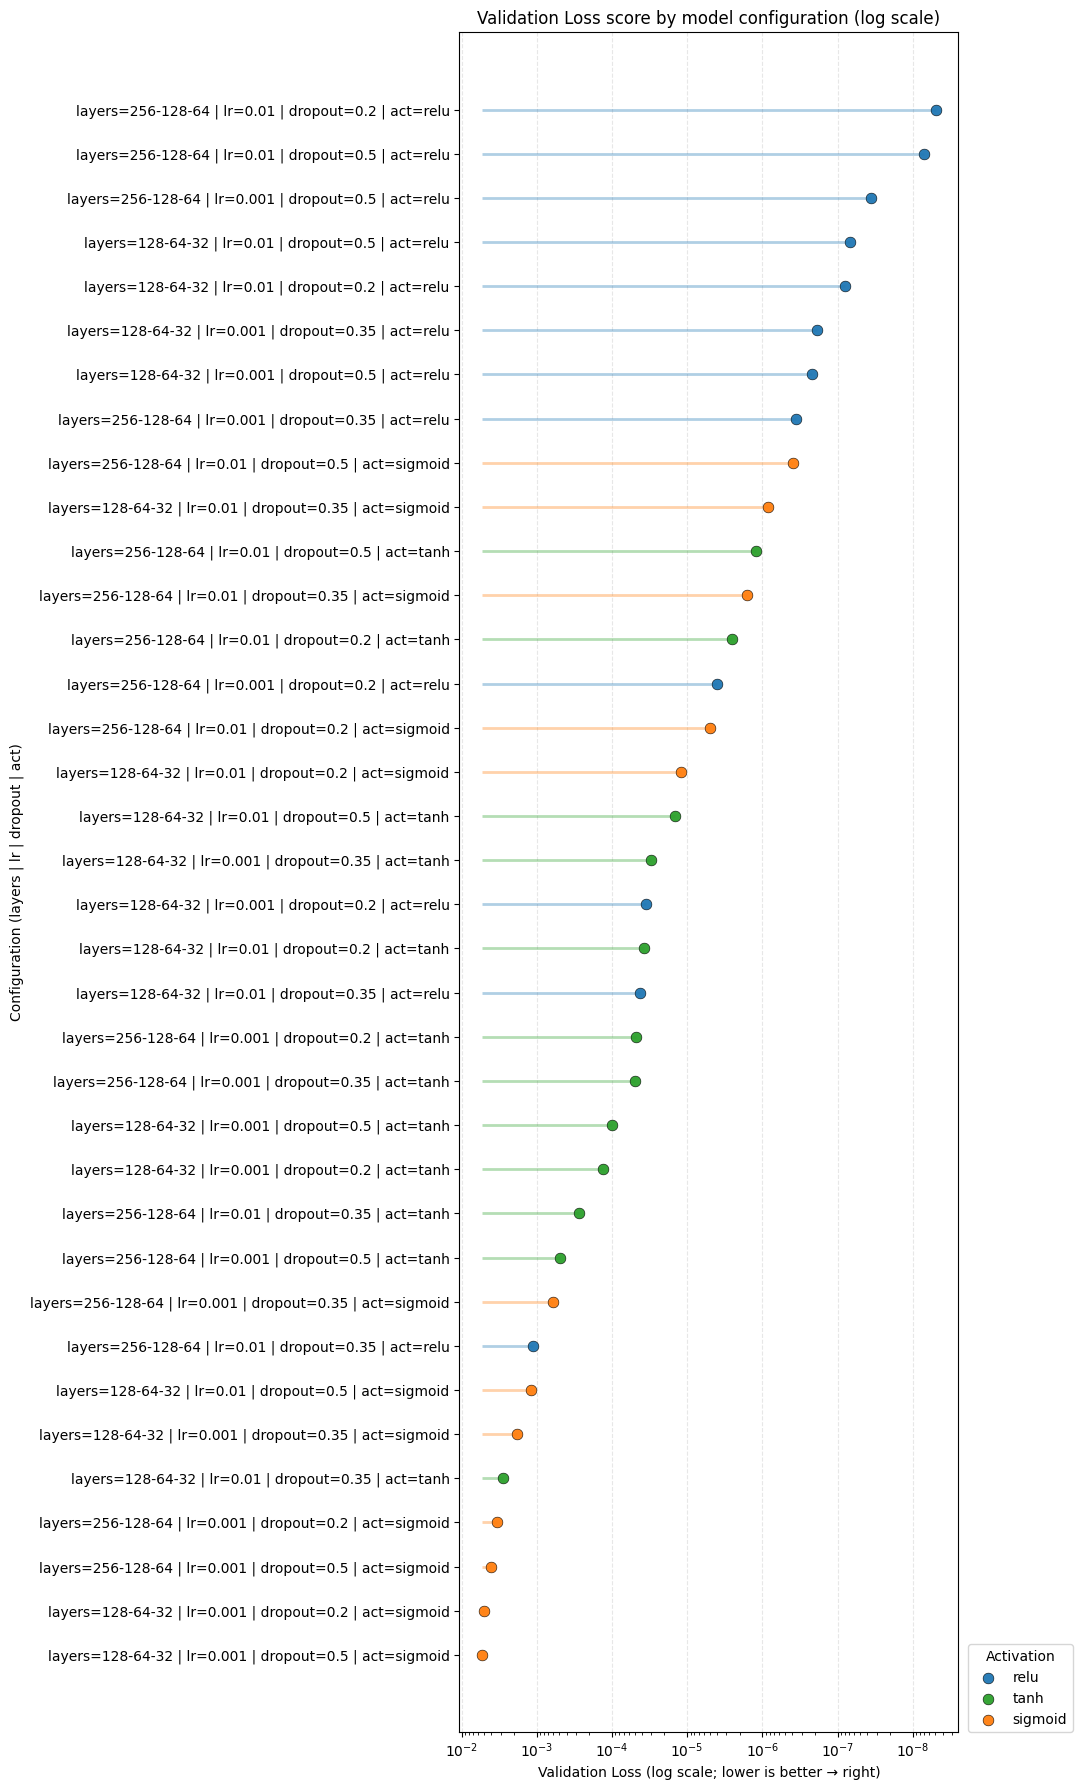

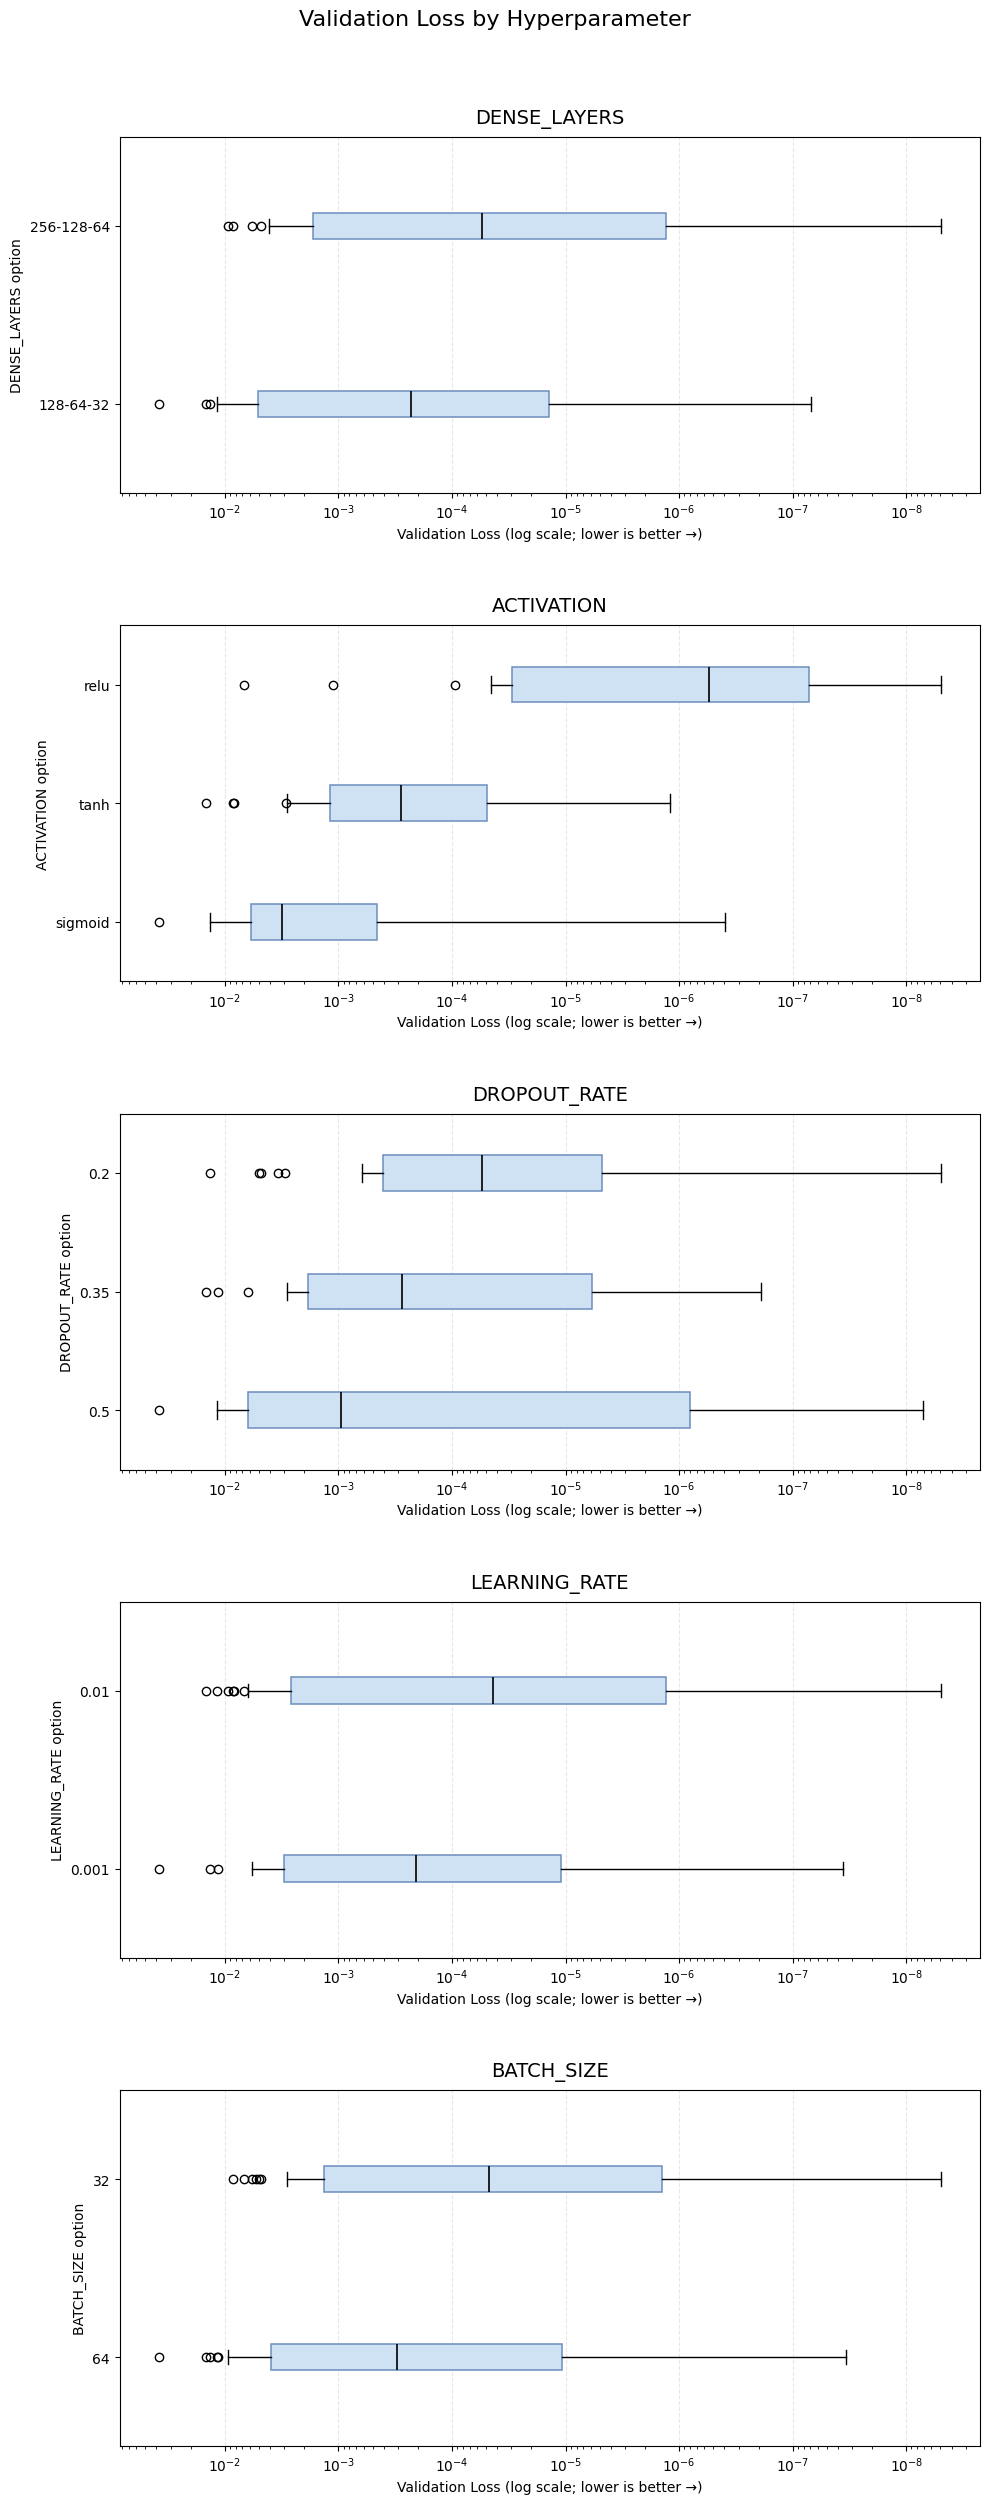

In [5]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
import pandas as pd
import sys
import os

config = AppConfig()
paths = config.get_neural_network_config()
model_performance_path = paths.get('MODEL_PERFORMANCE_PATH')

df = pd.read_csv(model_performance_path)
plot_helper = PlotHelper()
plot_helper.plot_model_val_loss_score(df)
plot_helper.plot_val_loss_by_parameter(df)

<a id="evaluation"></a>
## 4. In-Depth Evaluation of the Best Model

Once the best-performing model has been identified from the hyperparameter search, we conduct a more detailed evaluation. This section focuses exclusively on the "winner" model to understand its learning dynamics, classification accuracy, and the structure of its predictions.

### Interpreting the Plots

The following code cell will generate several visualizations to assess the best model:

1.  **Training & Validation Curves (Loss and Accuracy)**: These plots show the model's loss and accuracy on both the training and validation sets over each epoch.
    *   **What to look for**: We want to see both curves converging. If the training loss/accuracy improves but the validation loss/accuracy stagnates or worsens, it's a sign of **overfitting**. A healthy model shows both curves improving and stabilizing.
2.  **Confusion Matrix**: This matrix provides a detailed breakdown of classification performance for each gesture.
    *   **How to read it**: The diagonal elements show the number of correct predictions for each class. Off-diagonal elements show where the model made mistakes (i.e., which gestures it confused with others). A perfect model would have a bright diagonal and dark off-diagonals.
3.  **ROC Curve (Receiver Operating Characteristic)**: This plot illustrates the diagnostic ability of the classifier as its discrimination threshold is varied.
    *   **What it means**: The Area Under the Curve (AUC) is a key metric. An AUC of 1.0 represents a perfect classifier, while an AUC of 0.5 represents a model with no discriminative power (equivalent to random guessing). We aim for curves that are pushed towards the top-left corner.
4.  **PCA and t-SNE Plots**: These are dimensionality reduction techniques used to visualize the high-dimensional landmark data in 2D.
    *   **What they show**: The plots show how the model's predictions cluster the data points. Well-separated clusters for each gesture indicate that the model has learned discriminative features and can distinguish between the classes effectively. Overlapping clusters may indicate which gestures are harder for the model to tell apart.

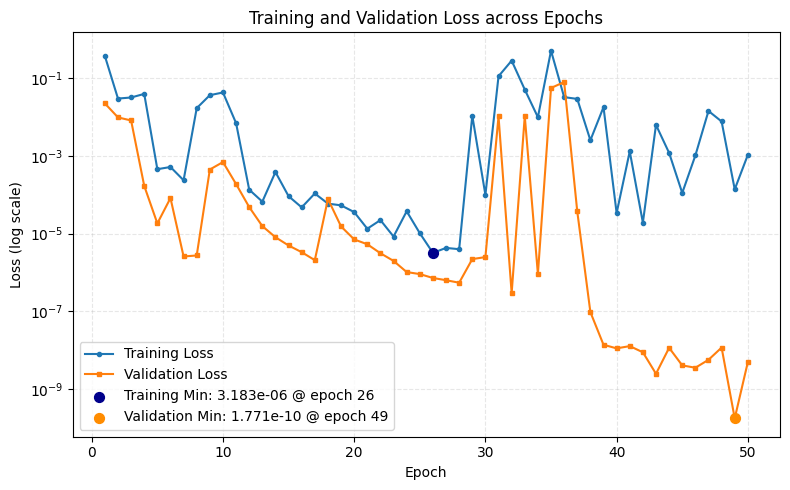

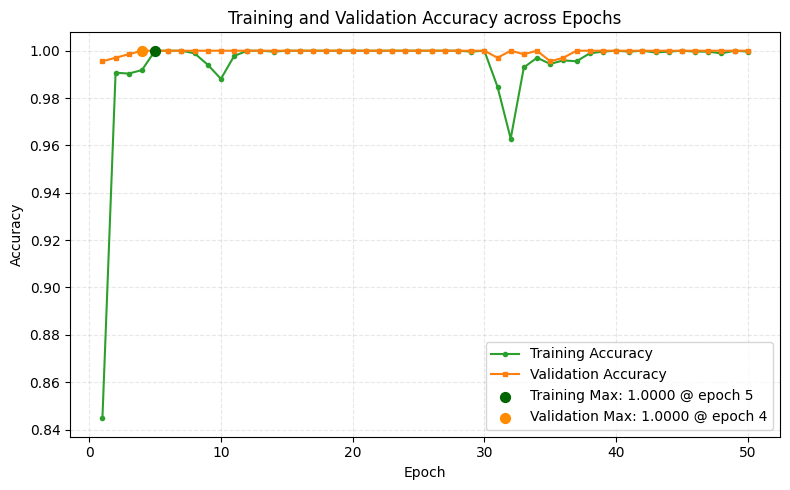

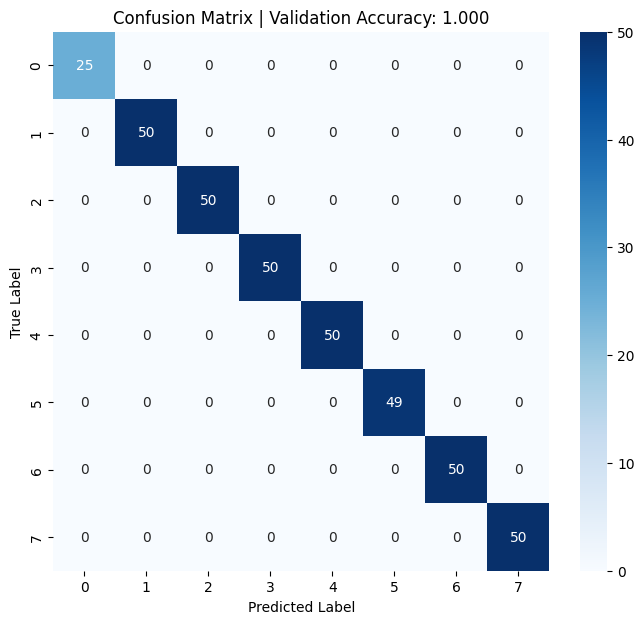

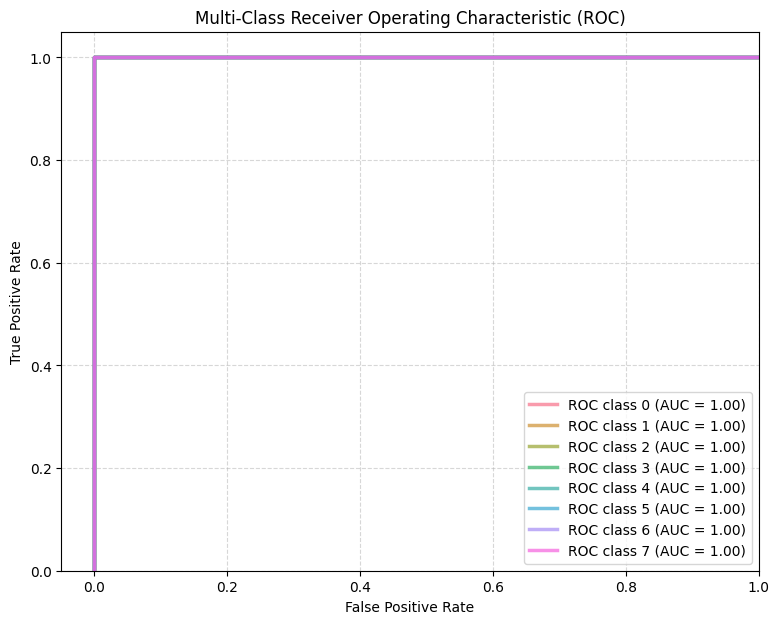

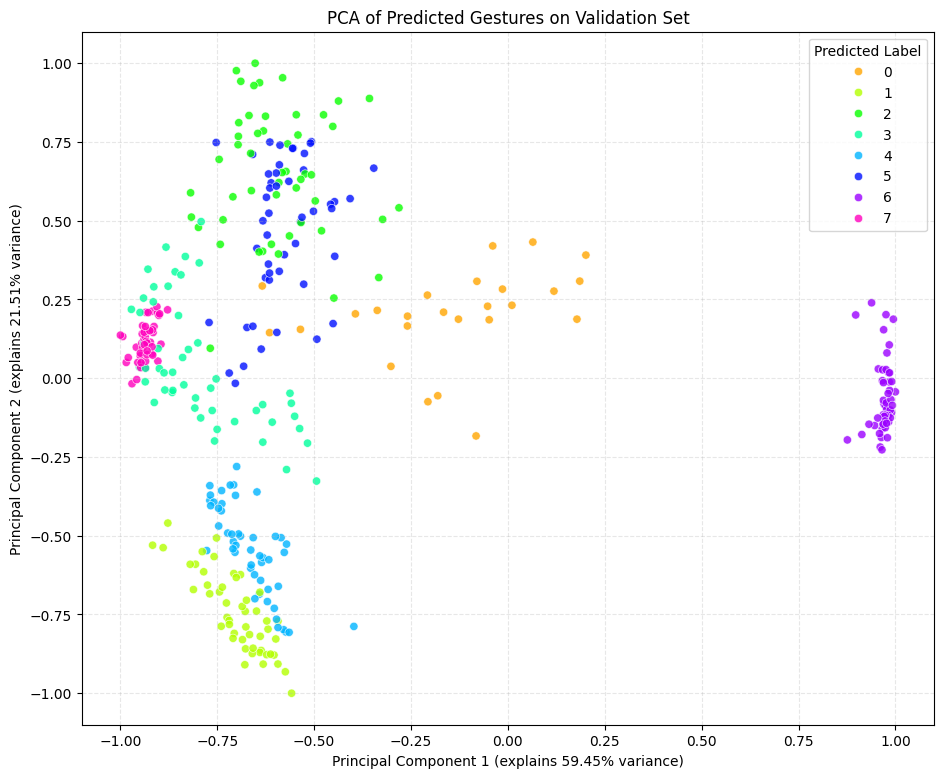

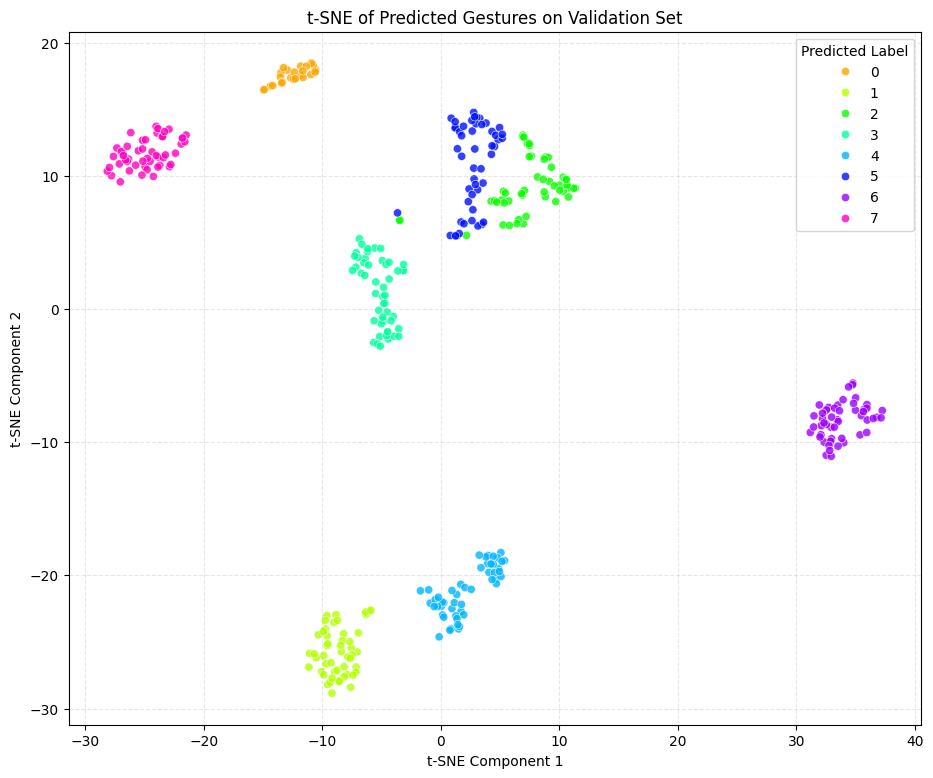

In [8]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os

# Resolve paths from config
config = AppConfig()

data_generation_config = config.get_app_config("DATA_GENERATION_CONFIG")
datase_val_path = data_generation_config.get("DATASET_VAL_PATH")

nn_config = config.get_neural_network_config()
model_path = nn_config.get('MODEL_PATH')
model_performance_path = nn_config.get('MODEL_PERFORMANCE_PATH')


df = pd.read_csv(model_performance_path)
winner = df.sort_values(by=['val_accuracy', 'val_loss'], ascending=[False, True]).iloc[0]
plot_helper = PlotHelper()
plot_helper.plot_loss_in_epochs(winner)
plot_helper.plot_accuracy_in_epochs(winner)


# Load dataset
df = pd.read_csv(datase_val_path)
df['LANDMARKS'] = df['LANDMARKS'].apply(eval)
X = np.array(df['LANDMARKS'].tolist())
Y = df['GESTURE_ID'].to_numpy()

# Load model and predict
model = tf.keras.models.load_model(model_path)
probs = model.predict(X, verbose=0)
y_pred = np.argmax(probs, axis=1)

# Confusion matrix plot
classes = np.unique(Y)
plot_helper.plot_heatmap(Y, y_pred, classes)

# ROC plot
plot_helper.plot_roc_curve(Y, probs, classes)

# PCA Visualization plot
plot_helper.plot_pca(X, y_pred)

# t-SNE Visualization plot
plot_helper.plot_tsne(X, y_pred)